In [18]:
# SLOT 1: Setup & Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# อ่านไฟล์ CSV (ไฟล์ต้องอยู่โฟลเดอร์เดียวกับ notebook หรือ /content/ ใน Colab)
df = pd.read_csv("dataset\Sleep_data__norm_ML2568.csv")
print("Loaded dataset shape:", df.shape)

# drop col with no norm in its name and print the dropped names
cols_to_drop = [col for col in df.columns if 'norm' not in col]
df = df.drop(columns=cols_to_drop)
print("Dataset shape after dropping non-norm columns:", df.shape)
print("Dropped columns:", cols_to_drop)


Loaded dataset shape: (11470, 143)
Dataset shape after dropping non-norm columns: (11470, 137)
Dropped columns: ['Unnamed: 0', 'pid', 'date', 'f_slp:fitbit_sleep_summary_rapids_avgefficiencymain:allday', 'f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:allday', 'date_']


In [19]:
# SLOT 2: Cleaning & Preprocessing

# 2.1 ดรอปคอลัมน์ที่ missing > 50%
missing_ratio = df.isnull().sum() / len(df)
df = df.loc[:, missing_ratio <= 0.5]
print("After dropping high-missing cols shape:", df.shape)

# 2.2 แยก numeric / non-numeric
numeric_cols = df.select_dtypes(include=[np.number]).columns

# 2.3 เติม missing ของ numeric ด้วย median
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

print("After cleaning shape:", df.shape)
print("Still missing: ", df.isnull().sum().sum(), "cells")
df.head()


After dropping high-missing cols shape: (11470, 75)
After cleaning shape: (11470, 75)
Still missing:  0 cells


,f_slp:fitbit_sleep_summary_rapids_avgefficiencymain_norm:allday,f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain_norm:allday,f_blue:phone_bluetooth_doryab_uniquedevicesall_norm:allday,f_blue:phone_bluetooth_doryab_uniquedevicesall_norm:afternoon,f_blue:phone_bluetooth_doryab_uniquedevicesall_norm:evening,f_blue:phone_bluetooth_doryab_uniquedevicesall_norm:morning,f_loc:phone_locations_doryab_movingtostaticratio_norm:afternoon,f_loc:phone_locations_doryab_timeathome_norm:afternoon,f_loc:phone_locations_doryab_totaldistance_norm:afternoon,f_loc:phone_locations_locmap_duration_in_locmap_study_norm:afternoon,...,f_steps:fitbit_steps_intraday_rapids_sumdurationactivebout_norm:allday,f_steps:fitbit_steps_intraday_rapids_sumsteps_norm:evening,f_steps:fitbit_steps_intraday_rapids_countepisodeactivebout_norm:evening,f_steps:fitbit_steps_intraday_rapids_sumdurationactivebout_norm:evening,f_steps:fitbit_steps_intraday_rapids_sumsteps_norm:morning,f_steps:fitbit_steps_intraday_rapids_countepisodeactivebout_norm:morning,f_steps:fitbit_steps_intraday_rapids_sumdurationactivebout_norm:morning,f_steps:fitbit_steps_intraday_rapids_sumsteps_norm:night,f_steps:fitbit_steps_intraday_rapids_countepisodeactivebout_norm:night,f_steps:fitbit_steps_intraday_rapids_sumdurationactivebout_norm:night
0,0.141844,-0.294479,0.0,0.0,0.0,0.0,0.000024,0.0,-0.000246,0.0,...,0.166485,0.019403,0.363636,0.019737,-0.203456,-0.310345,-0.315789,0.938046,0.607143,0.818505
1,-0.425532,-0.147239,0.0,0.0,0.0,0.0,0.000024,0.0,-0.000246,0.0,...,0.002729,-0.133076,-0.242424,-0.256579,0.713246,-0.103448,0.210526,0.275539,0.785714,0.344009
2,0.141844,0.392638,0.0,0.0,0.0,0.0,0.000024,0.0,-0.000246,0.0,...,0.092795,0.196206,0.424242,0.190789,0.393885,0.034483,0.105263,0.178433,0.321429,0.189798
3,0.283688,-0.273006,0.0,0.0,0.0,0.0,0.000024,0.0,-0.000246,0.0,...,0.030022,0.069661,-0.090909,-0.006579,-0.206330,0.000000,0.000000,0.173092,0.285714,0.201661
4,0.141844,0.472393,0.0,0.0,0.0,0.0,0.000024,0.0,-0.000246,0.0,...,0.322052,0.337990,-0.090909,0.217105,0.062263,0.241379,0.017544,0.314381,0.535714,0.450771


In [20]:
# SLOT 3: Feature / Target Split

target_col = 'f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain_norm:allday'

X = df.drop(columns=[target_col], errors='ignore')
y = df[target_col]

# เก็บเฉพาะคอลัมน์เชิงตัวเลข (MLP รับแต่ตัวเลข)
X = X.select_dtypes(include=[np.number])

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Example feature columns:", list(X.columns[:8]))


X shape: (11470, 74)
y shape: (11470,)
Example feature columns: ['f_slp:fitbit_sleep_summary_rapids_avgefficiencymain_norm:allday', 'f_blue:phone_bluetooth_doryab_uniquedevicesall_norm:allday', 'f_blue:phone_bluetooth_doryab_uniquedevicesall_norm:afternoon', 'f_blue:phone_bluetooth_doryab_uniquedevicesall_norm:evening', 'f_blue:phone_bluetooth_doryab_uniquedevicesall_norm:morning', 'f_loc:phone_locations_doryab_movingtostaticratio_norm:afternoon', 'f_loc:phone_locations_doryab_timeathome_norm:afternoon', 'f_loc:phone_locations_doryab_totaldistance_norm:afternoon']


In [21]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


In [22]:
def train_evaluate_model(model, X, y, model_name="Model", n_splits=5, scale=False, plot_last_fold=True):
    """
    Train and evaluate a regression model using K-Fold CV.

    Parameters:
        model: sklearn-like or XGBoost model with .fit() and .predict()
        X: pandas DataFrame or numpy array of features
        y: pandas Series or numpy array of target
        model_name: string, name of the model for display
        n_splits: int, number of K-Folds
        scale: bool, whether to standardize features (recommended for MLP/Linear models)
        plot_last_fold: bool, whether to plot predictions of the last fold
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    mae_list, rmse_list, r2_list = [], [], []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Properly select rows for pandas or numpy
        if hasattr(X, "iloc"):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        else:
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
    
        # Optionally scale
        if scale:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled  = scaler.transform(X_test)
        else:
            X_train_scaled = X_train.values if hasattr(X_train, "values") else X_train
            X_test_scaled  = X_test.values if hasattr(X_test, "values") else X_test
    
        # Train model
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # Evaluate
        mae  = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2   = r2_score(y_test, y_pred)

        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)

        print(f"{model_name} — Fold {fold} | MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # Print average metrics
    print(f"\n{model_name} — Average across {n_splits} folds:")
    print(f"MAE  : {np.mean(mae_list):.4f}")
    print(f"RMSE : {np.mean(rmse_list):.4f}")
    print(f"R²   : {np.mean(r2_list):.4f}")

    # Plot last fold
    if plot_last_fold:
        plt.figure(figsize=(6,6))
        plt.scatter(y_test, y_pred, alpha=0.5, color='darkorange')
        plt.xlabel("Actual Sleep Duration (normalized)")
        plt.ylabel("Predicted Sleep Duration (normalized)")
        plt.title(f"{model_name} — Predicted vs Actual (Last Fold)")

        low, high = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
        plt.plot([low, high], [low, high], 'r--')
        plt.show()
    
    return np.mean(mae_list), np.mean(rmse_list), np.mean(r2_list)

MLP Regressor — Fold 1 | MAE: 0.2335, RMSE: 0.3250, R²: -0.5392
MLP Regressor — Fold 2 | MAE: 0.2466, RMSE: 0.3355, R²: -0.6699
MLP Regressor — Fold 3 | MAE: 0.2348, RMSE: 0.3255, R²: -0.5320
MLP Regressor — Fold 4 | MAE: 0.2391, RMSE: 0.3398, R²: -0.5029
MLP Regressor — Fold 5 | MAE: 0.2393, RMSE: 0.3481, R²: -0.5062

MLP Regressor — Average across 5 folds:
MAE  : 0.2387
RMSE : 0.3348
R²   : -0.5500


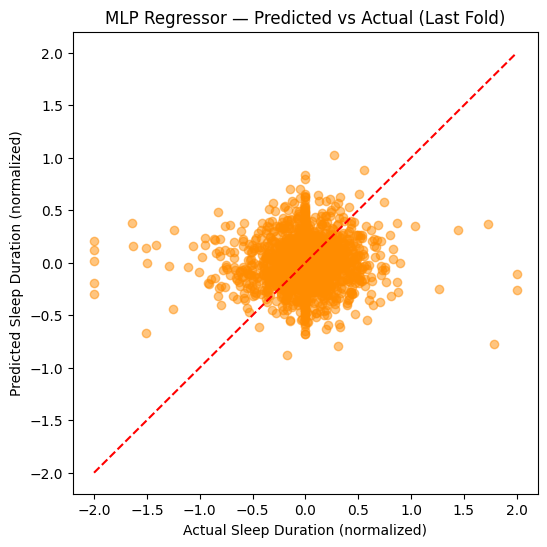

In [23]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(512, 256, 128),  # network ลึกขึ้นกว่าของเดิม
    activation='relu',
    solver='adam',
    learning_rate_init=0.0001,
    max_iter=10000,     # ให้เรียนรู้ได้นานขึ้น
    random_state=42
)

mlp_metrics = train_evaluate_model(mlp, X, y, model_name="MLP Regressor", n_splits=5, scale=False)

XGBoost — Fold 1 | MAE: 0.1644, RMSE: 0.2686, R²: -0.0519
XGBoost — Fold 2 | MAE: 0.1650, RMSE: 0.2627, R²: -0.0239
XGBoost — Fold 3 | MAE: 0.1613, RMSE: 0.2641, R²: -0.0086
XGBoost — Fold 4 | MAE: 0.1671, RMSE: 0.2786, R²: -0.0103
XGBoost — Fold 5 | MAE: 0.1643, RMSE: 0.2868, R²: -0.0228

XGBoost — Average across 5 folds:
MAE  : 0.1644
RMSE : 0.2722
R²   : -0.0235


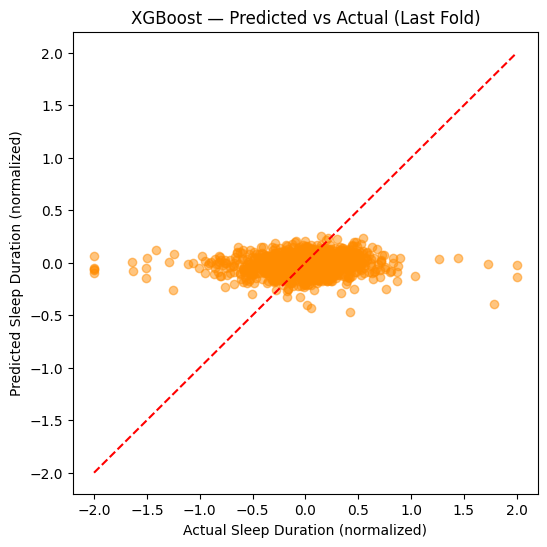

In [24]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.3,
    random_state=42,
    tree_method='hist'
)

xgb_metrics = train_evaluate_model(xgb_model, X, y, model_name="XGBoost", n_splits=5, scale=False)

Decision Tree — Fold 1 | MAE: 0.1671, RMSE: 0.2850, R²: -0.1840
Decision Tree — Fold 2 | MAE: 0.1756, RMSE: 0.2855, R²: -0.2098
Decision Tree — Fold 3 | MAE: 0.1711, RMSE: 0.2909, R²: -0.2232
Decision Tree — Fold 4 | MAE: 0.1774, RMSE: 0.3027, R²: -0.1926
Decision Tree — Fold 5 | MAE: 0.1789, RMSE: 0.3127, R²: -0.2155

Decision Tree — Average across 5 folds:
MAE  : 0.1740
RMSE : 0.2953
R²   : -0.2050


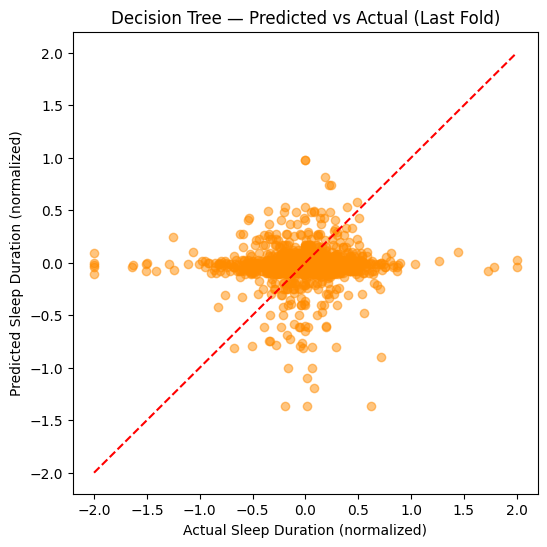

In [25]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(
    max_depth=10,          # ควบคุมความลึกของต้นไม้ (ลึกเกิน = overfit)
    min_samples_split=5,   # จำนวน sample ขั้นต่ำก่อน split
    min_samples_leaf=3,    # จำนวน sample ขั้นต่ำใน leaf node
    random_state=42
)

tree_metrics = train_evaluate_model(tree_model, X, y, model_name="Decision Tree", n_splits=5, scale=False)

Linear Regression — Fold 1 | MAE: 0.1620, RMSE: 0.2620, R²: -0.0009
Linear Regression — Fold 2 | MAE: 0.1645, RMSE: 0.2592, R²: 0.0028
Linear Regression — Fold 3 | MAE: 0.1609, RMSE: 0.2621, R²: 0.0071
Linear Regression — Fold 4 | MAE: 0.1676, RMSE: 0.2766, R²: 0.0041
Linear Regression — Fold 5 | MAE: 0.1647, RMSE: 0.2838, R²: -0.0013

Linear Regression — Average across 5 folds:
MAE  : 0.1640
RMSE : 0.2687
R²   : 0.0023


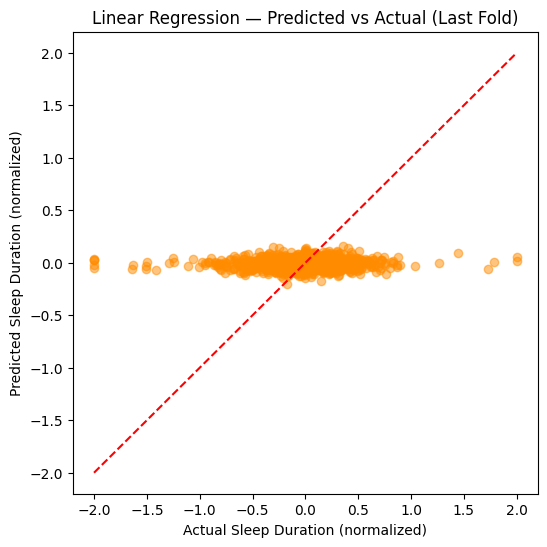

In [26]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_metrics = train_evaluate_model(lin_model, X, y, model_name="Linear Regression", n_splits=5, scale=True)

In [27]:
# SLOT 17: Compare All Models
results = pd.DataFrame({
    "Model": ["MLP Regressor", "XGBoost", "Decision Tree", "Linear Regression"],
    "MAE": [mlp_metrics[0], xgb_metrics[0], tree_metrics[0], lin_metrics[0]],
    "RMSE": [mlp_metrics[1], xgb_metrics[1], tree_metrics[1], lin_metrics[1]],
    "R²": [mlp_metrics[2], xgb_metrics[2], tree_metrics[2], lin_metrics[2]],
})

results = results.sort_values(by='R²', ascending=False)
print(results)


               Model       MAE      RMSE        R²
3  Linear Regression  0.163956  0.268745  0.002340
1            XGBoost  0.164421  0.272168 -0.023499
2      Decision Tree  0.174041  0.295350 -0.205015
0      MLP Regressor  0.238654  0.334755 -0.550043
